# MNIST Digit Decomposition

This project decomposes the MNIST Digit data set to pre-process each image extracting the Principal Components after applying the Discrete Cosine Transformation

In [1]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture

## Data

This data is set up in a csv file which will require the reshaping of the data to be 28 × 28 matrix representing images. There are 42000 images in the train.csv file. For this problem it is only necessary to process approximately 100 images, 10 each of the numbers from 0 through 9. The goal is to learn how to generate features from images using transforms and first order statistics

In [2]:
# Read the data and split it into 2 data sets, features and the label.

df_train = pd.read_csv('train.csv')

Y = df_train.iloc[:,0]
X = df_train.iloc[:,1:]

df_train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


I developed the following algorithm to reshape each row into a 28x28. It takes the first 100 rows and iterates over each column calculating the place in the 28x28 matrix by splitting it into i and j. Every 28 columns change the row and repeat.

```
for index in range(0,99):
  label = df_train.iloc[index, 0]
  image
  for column in range(1,len(df_train.columns)):
    pixel = df_train.columns[column]
    x = int(pixel.replace('pixel',''))
    i = np.floor(x/28)
    j = np.abs(x - 28*i)
```

In [3]:
# Reshape the columns into 28x28

images = []
imgIndexes = []
imgLabels = []
imgCount = [0]*10
cont = 0
data_length = 5000

for index, row in X.iterrows():
  label = Y[index]
  #if imgCount[label] < data_length / 100:  # Uncomment and fix identation to balance dataset
  r = row.to_numpy().reshape(28,28)  # Used numpy reshape for simplicity
  images.append(r)
  imgIndexes.append(index)
  imgLabels.append(label)
  imgCount[label] += 1
  cont += 1
  
  if cont == data_length:
    break


In [4]:
# Number of images per number from 0 to 9
print(imgCount)


[494, 558, 545, 480, 477, 469, 516, 506, 477, 478]


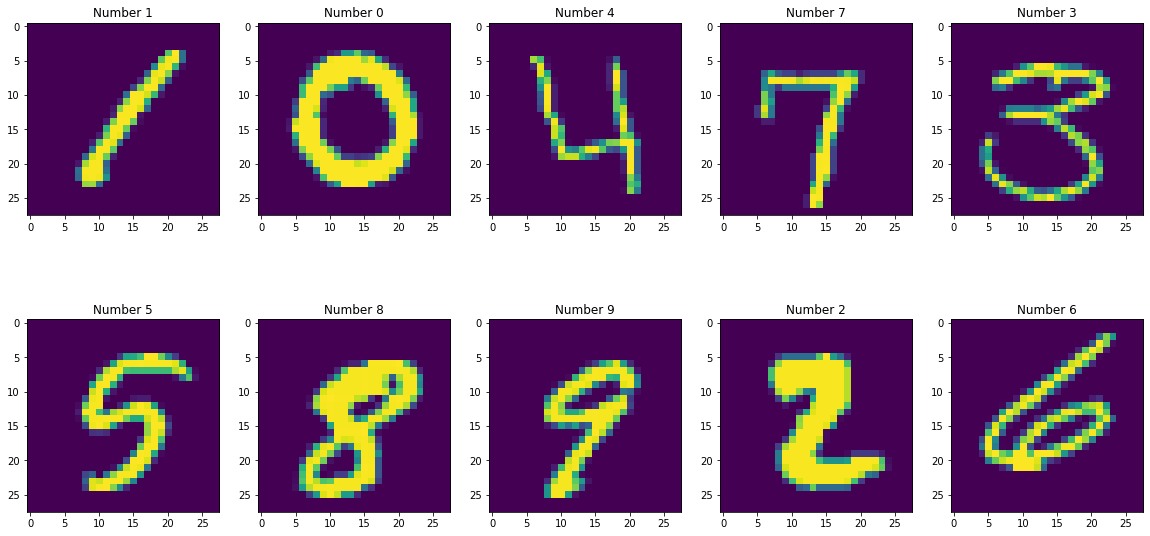

In [5]:
# Used imshow from matplotlib to print the 10 images in a single figure

fig = plt.figure(figsize = (20, 10))
j = 0
indexes = [0, 1, 3, 6, 7, 8, 10, 11, 16, 21] # Python is 0 indexed. 
for index in indexes:
  r = images[index]
  ax1 = plt.subplot(2, 5, j+1)
  imgplot = plt.imshow(r)
  ax1.title.set_text(f'Number {imgLabels[index]}')
  j += 1



## Processing

Each image from the train.csv is to be processed to generate a set of features using the discrete cosine transform and principal component analysis.

### Extracting the vertical, horizontal and diagonal coefficients from the DCT.

In [6]:
def nDCT2(n=28):
  '''
  This function produces the N−point DCT 2 of an input size received.
  The N−point DCT 2 matrix will be a square matrix in this function.
  n: the N-point number
  Returns a nxn matrix with the DCT2 Matrix
  '''
  npDCT = np.zeros((n,n))
  for k in range(0,n):
    for i in range(0,n):
      if k == 0:
        npDCT[k][i] = math.sqrt(1/n) # Eq 57
      else:
        npDCT[k][i] = math.sqrt(2/n) * math.cos(( np.pi*(2*i + 1)*k)/(2*n)) # Eq 57
  return npDCT

In [7]:
# Define the masks to be applied for diagonal, vertical and horizontal coefficients
# Stored as numpy 1D arrays

diagMask = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
            0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,
            0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
            0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
            0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
            0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
            0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
            0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
            0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
            0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
            0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
            0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
            0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
            0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
            0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
            0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
            0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]

vertMask = [0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
            0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
            0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
            0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
            0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
            0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
            0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
            0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
            0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
            0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,
            0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,
            0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,
            0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,
            0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]

horizMask = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
             1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
             1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
             1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
             1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
             1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
             1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
             1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
             1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
             1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
             1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
             1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
             1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
             1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
             1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
             1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
             1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
             1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
             1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
             1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
             1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
             1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
             1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
             1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
             1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
             1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
             1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
             1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]

diagMask = np.array(diagMask)
vertMask = np.array(vertMask)
horizMask = np.array(horizMask)

In [8]:
# Find the indexes where the the masks are applied
indexD = np.where(diagMask==1)[0]
indexV = np.where(vertMask==1)[0]
indexH = np.where(horizMask==1)[0]

In [9]:
# Proving the length of indexes
print(len(indexD))
print(len(indexV))
print(len(indexH))

335
224
224


In [18]:
# Calculating the DCT transformed for each image
# CBC = C * B * C^T where C is the 28 point DCT2 matrix and B is the image matrix
DCT = []

DCT_Coef_V = []
DCT_Coef_H = []
DCT_Coef_D = []
C = nDCT2()
for B in images:
  left = np.dot(C, B)
  CBC = np.dot(left, C.T)
  DCT.append( CBC )
  CBC_array =  abs(CBC.reshape(784)) #CBC.reshape(784) #ABS changes the Principal Componetens as shown. Still usefull
  
  vert_coef = CBC_array[indexV] # Pulling the vertical coefficients
  horz_coef = CBC_array[indexH] # Pulling the horizontal coefficients
  diag_coef = CBC_array[indexD] # Pulling the diagonal coefficients
  
  DCT_Coef_V.append(vert_coef)
  DCT_Coef_H.append(horz_coef)
  DCT_Coef_D.append(diag_coef)

# Transforming into a numpy 2D array
DCT_Coef_V = np.array(DCT_Coef_V)
DCT_Coef_H = np.array(DCT_Coef_H)
DCT_Coef_D = np.array(DCT_Coef_D)

In [19]:
# Proving the shape, should be 1000 x 335, 1000 x 224, and 1000 x 224 for diagonal, vertical and horizontal
print(DCT_Coef_V.shape)
print(DCT_Coef_H.shape)
print(DCT_Coef_D.shape)

(5000, 224)
(5000, 224)
(5000, 335)


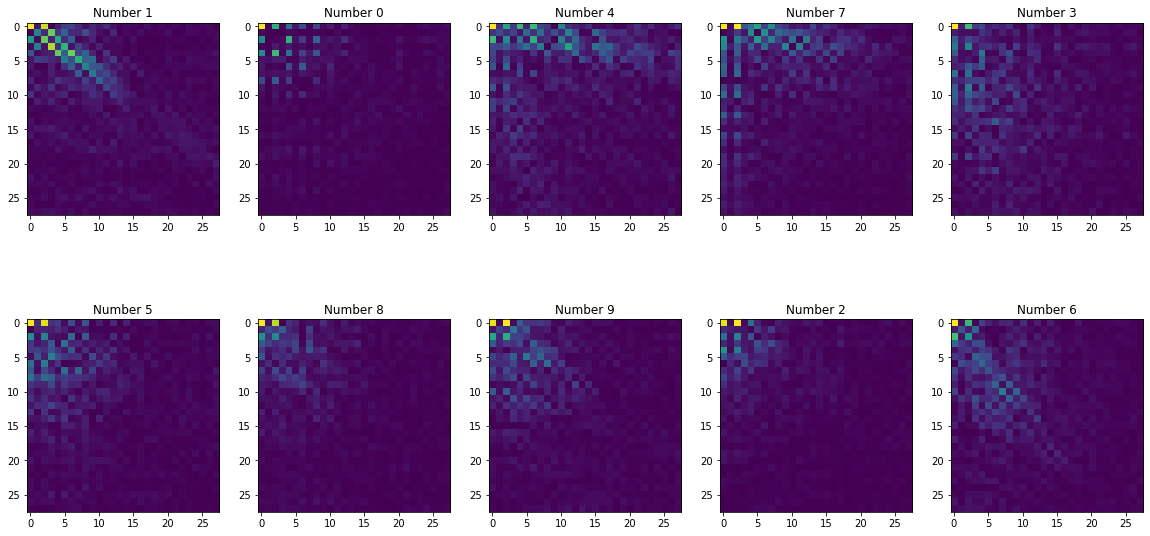

In [20]:
# Plot of the DCT transfomed matrix for the 10 images (2C)
fig = plt.figure(figsize = (20, 10))
j = 0
indexes = [0, 1, 3, 6, 7, 8, 10, 11, 16, 21]
for index in indexes:
  d = DCT[index]
  ax1 = plt.subplot(2, 5, j+1)
  imgplot = plt.imshow(abs(d)) # Plotting the absolute value of DCT
  ax1.title.set_text(f'Number {imgLabels[index]}')
  j += 1


### For each of the three sets of DCT coefficients perform Principal Component Analysis (PCA).

In [21]:
# Calculating all the principal components for the three sets
# Using sklearn decompostion PCA pre-built function
pcaD = PCA()
data_pca_D = pcaD.fit_transform(DCT_Coef_D) # Initially taking all the principal components

pcaV = PCA()
data_pca_V = pcaV.fit_transform(DCT_Coef_V)

pcaH = PCA()
data_pca_H = pcaH.fit_transform(DCT_Coef_H)

In [141]:
# Calculating the eingenvalues of the eingenvectors of each component. 

covD = np.cov(DCT_Coef_D.T) # Covariance of the Diagonal matrix
eingenvalues_D = []
for eigenvector in pcaD.components_:
    eingenvalues_D.append(np.dot(eigenvector.T, np.dot(covD, eigenvector))) # e^T * S * e


covV = np.cov(DCT_Coef_V.T) # Covariance of the Vertical matrix
eingenvalues_V = []
for eigenvector in pcaV.components_:
    eingenvalues_V.append(np.dot(eigenvector.T, np.dot(covV, eigenvector)))

covH = np.cov(DCT_Coef_H.T) # Covariance of the Horizontal matrix
eingenvalues_H = []
for eigenvector in pcaH.components_:
    eingenvalues_H.append(np.dot(eigenvector.T, np.dot(covH, eigenvector)))



In [142]:
# Amount of eingenvalues

print(len(eingenvalues_D))
print(len(eingenvalues_V))
print(len(eingenvalues_H))

335
224
224


### Retain the top n number of principal components

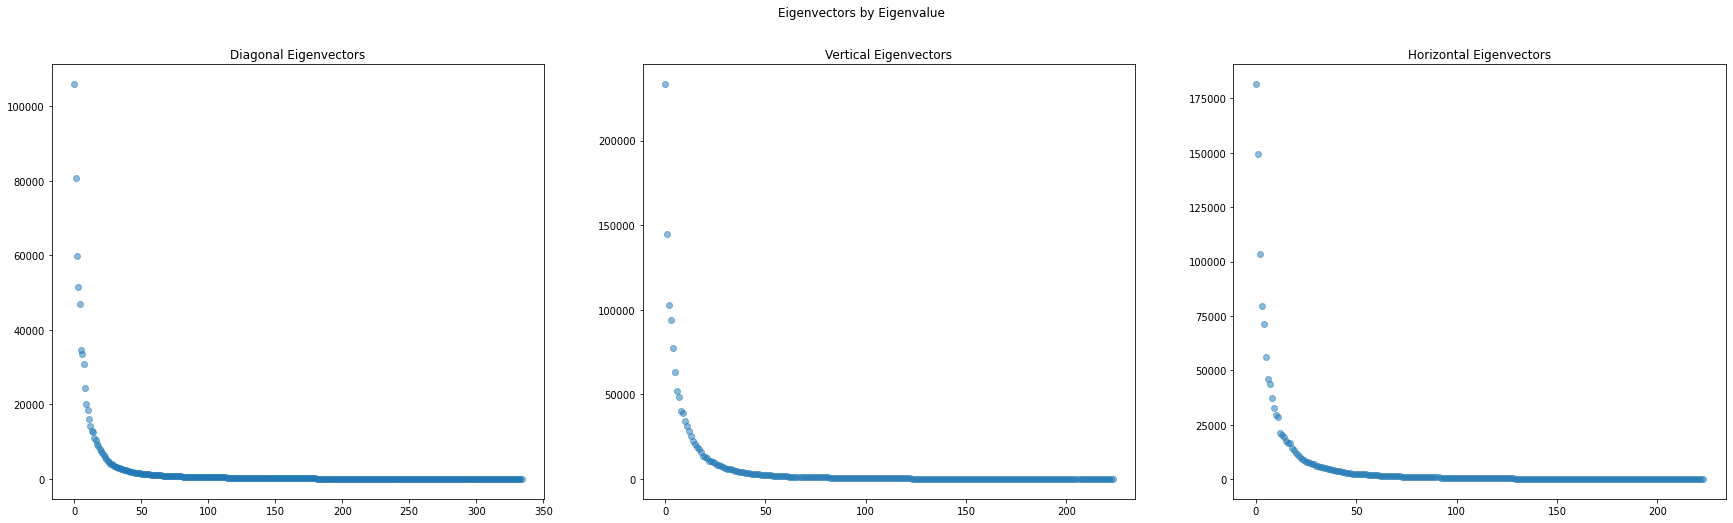

In [143]:
# Ploting the eingenvalues per eingenvector
# Proving that the eingenvectors are ordered descending by eingenvalue
# Using a Scree test to dertermine the n, m, k top enigenvectors

fig = plt.figure(figsize = (30, 8))

ax1 = plt.subplot(1, 3, 1)
plt.scatter(range(0,len(eingenvalues_D)),eingenvalues_D ,alpha=0.5)
ax1.title.set_text('Diagonal Eigenvectors')

ax1 = plt.subplot(1, 3, 2)
plt.scatter(range(0,len(eingenvalues_V)),eingenvalues_V ,alpha=0.5)
ax1.title.set_text('Vertical Eigenvectors')

ax1 = plt.subplot(1, 3, 3)
plt.scatter(range(0,len(eingenvalues_H)),eingenvalues_H ,alpha=0.5)
ax1.title.set_text('Horizontal Eigenvectors')


fig.suptitle('Eigenvectors by Eigenvalue')
plt.show()

In [14]:
# I chose to use the top 35 components as in the graph it apears to be the elbow.
n, m, k = 15, 10, 10

### Using the top principal components we reduce the DCT transformed data.

In [22]:
# Concatenate the 3 coefficient matrixes by column. 
new_features = np.concatenate((data_pca_D[:,0:n], data_pca_V[:,0:m], data_pca_H[:,0:k]), axis=1)
df_new_features = pd.DataFrame(new_features, columns=[f'pca_{x}' for x in range(0,n+m+k)])
df_new_features['label'] = imgLabels # Concatenating label column at the end
df_new_features.head()

,pca_0,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,pca_8,pca_9,...,pca_26,pca_27,pca_28,pca_29,pca_30,pca_31,pca_32,pca_33,pca_34,label
0,141.900757,54.009399,403.609547,297.251556,-36.227445,111.242911,-107.911202,15.355582,-12.395326,168.205273,...,-109.212530,129.584944,10.159623,-112.879240,-133.792248,47.051286,127.202231,23.377645,-51.782986,1
1,-343.149827,-349.751507,73.574113,401.989356,36.870639,15.308825,14.857044,-53.812293,150.107896,116.781763,...,-632.762138,606.996219,-274.620476,33.132894,456.403467,-120.111514,-12.736236,-148.414831,144.502957,0
2,-430.705611,121.142644,-80.077282,72.675382,49.608389,7.877092,-42.217266,-108.516244,60.568989,-48.053408,...,-260.376177,175.165962,55.820797,-11.959030,115.486286,-48.645271,46.328102,-13.665989,49.507192,1
3,-387.038173,61.570239,8.785485,-83.695628,4.150469,-115.110064,-63.256876,-38.085438,-37.428757,-22.788773,...,-14.289696,-73.180765,112.010755,-127.509412,62.493395,-5.052676,97.673700,13.290036,-19.794641,4
4,-133.546049,-354.845697,37.792427,180.902635,146.423265,-118.154377,45.008999,-72.086089,117.182896,99.061114,...,-488.988060,595.017676,-254.410096,47.111103,541.722203,113.308047,-104.934133,-152.098836,153.391052,0


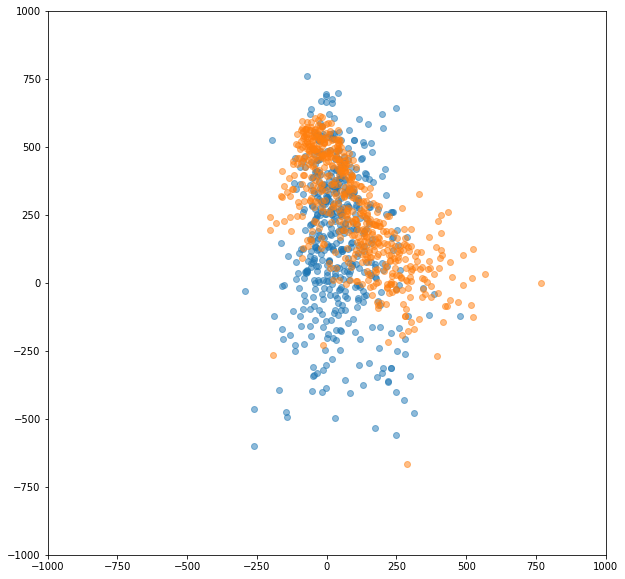

In [23]:
# Ploting the eingenvalues per eingenvector
# Proving that the eingenvectors are ordered descending by eingenvalue
# Using a Scree test to dertermine the n, m, k top enigenvectors

fig = plt.figure(figsize = (10, 10))
plt.scatter(df_new_features[df_new_features['label']==0]['pca_2'],df_new_features[df_new_features['label']==0]['pca_15'] ,alpha=0.5)
plt.scatter(df_new_features[df_new_features['label']==1]['pca_2'],df_new_features[df_new_features['label']==1]['pca_15'] ,alpha=0.5)

#plt.scatter(df_new_features[df_new_features['label']==3]['pca_2'],df_new_features[df_new_features['label']==3]['pca_15'] ,alpha=0.5)
#plt.scatter(df_new_features[df_new_features['label']==4]['pca_2'],df_new_features[df_new_features['label']==4]['pca_15'] ,alpha=0.5)
plt.xlim(-1000,1000)
plt.ylim(-1000,1000)
plt.show()

### Save the new data in a file

In [24]:
# Saving to CSV with headers and without indexes

df_new_features.to_csv('new_features_abs.csv', index=False)
